In [192]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns


In [193]:
df=pd.read_csv("Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [194]:
df.shape

(440, 8)

In [195]:
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [196]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [197]:
df.duplicated().sum()

np.int64(0)

skewness for Fresh: 2.561322751927935
skewness for Milk: 4.053754849210881
skewness for Grocery: 3.5874286903915453
skewness for Frozen: 5.9079856924559575
skewness for Detergents_Paper: 3.6318506306913645
skewness for Delicassen: 11.151586478906117


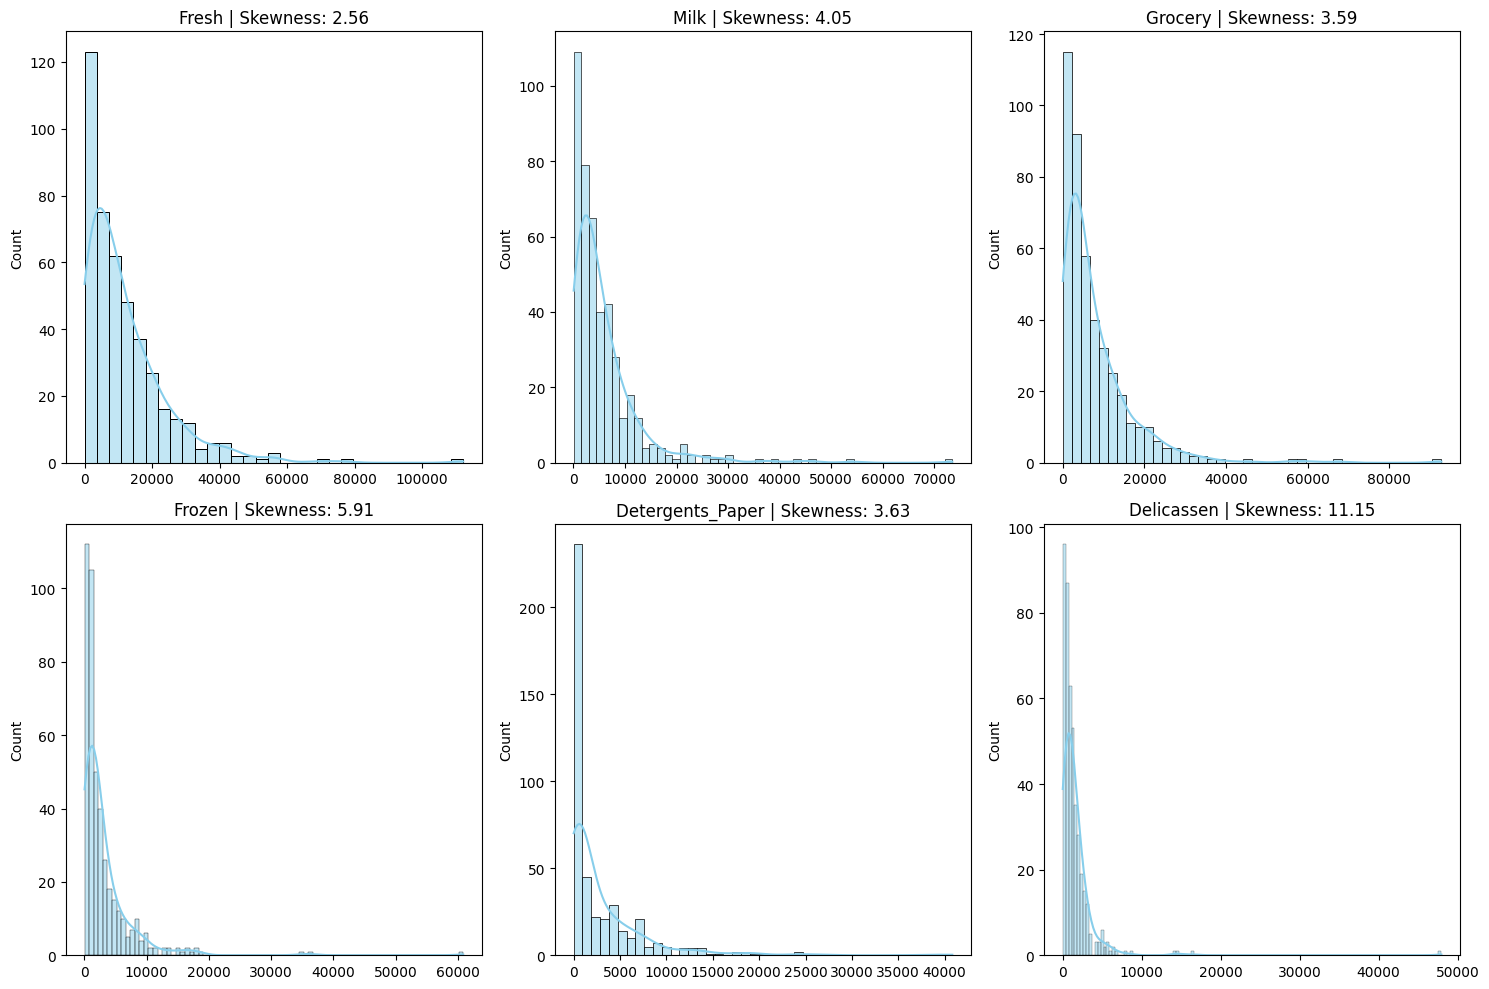

In [198]:
num_cols = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']

plt.figure(figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'{col} | Skewness: {df[col].skew():.2f}')
    plt.xlabel('')
    print(f"skewness for {col}:",df[col].skew())
    
plt.tight_layout()

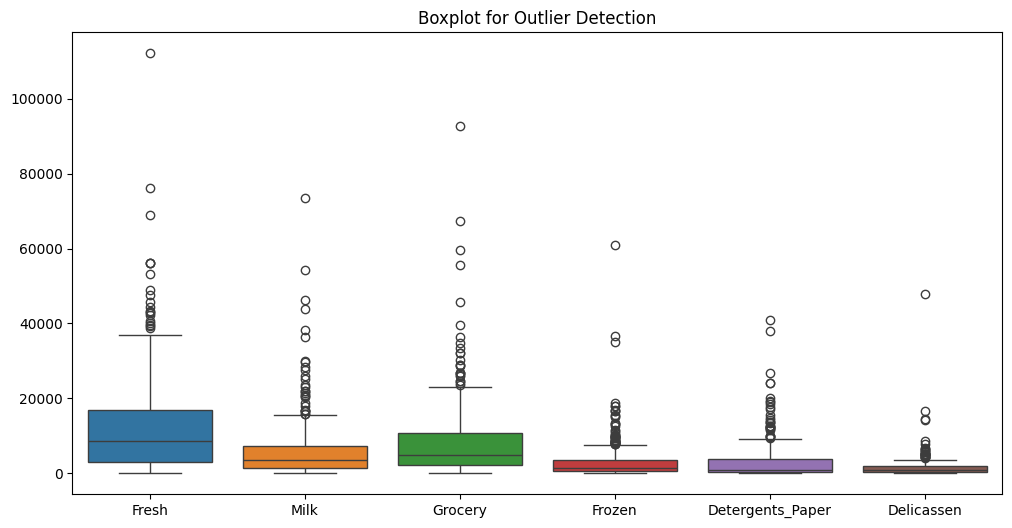

In [199]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']])
plt.title("Boxplot for Outlier Detection")
plt.show()

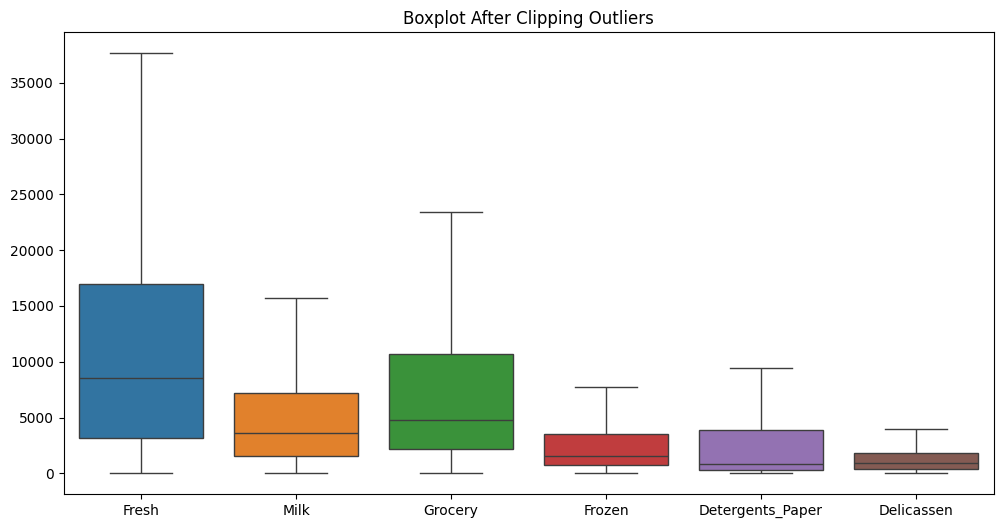

In [200]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Clip values to the bounds
    df[col] = df[col].clip(lower=lower, upper=upper)
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.title("Boxplot After Clipping Outliers")
plt.show()


In [201]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson') 
X_transformed = pt.fit_transform(df[num_cols])

df_transformed = pd.DataFrame(X_transformed, columns=num_cols)

for col in df_transformed.columns:
    print(f"{col}: skewness = {df_transformed[col].skew():.2f}")



Fresh: skewness = -0.12
Milk: skewness = -0.05
Grocery: skewness = -0.01
Frozen: skewness = -0.06
Detergents_Paper: skewness = -0.05
Delicassen: skewness = -0.08


In [202]:
X = df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

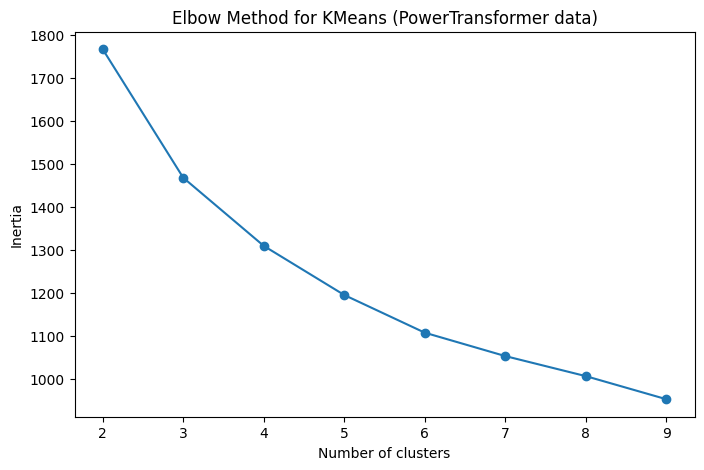

KMeans Silhouette Score (PowerTransformer data): 0.25862255822175634


In [203]:
X_scaled = df_transformed.values 

inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 10), inertia, marker='o')
plt.title("Elbow Method for KMeans (PowerTransformer data)")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
print("KMeans Silhouette Score (PowerTransformer data):", sil_kmeans)

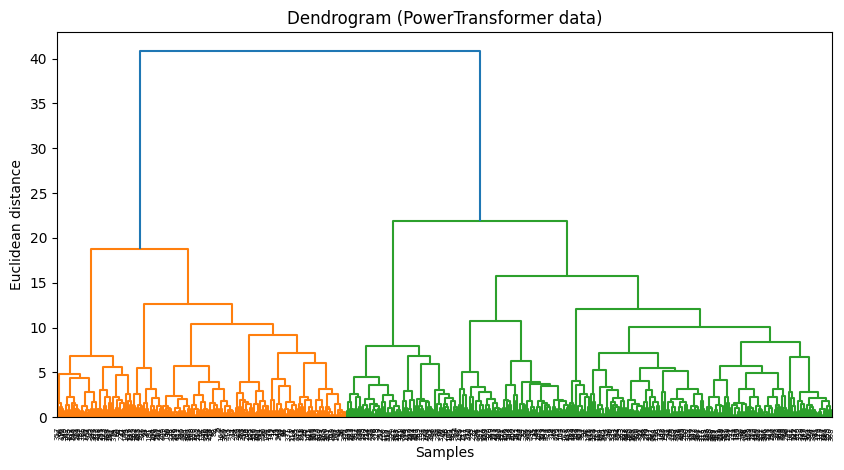

Hierarchical Clustering Silhouette Score (PowerTransformer data): 0.21207501803216766


In [204]:
plt.figure(figsize=(10,5))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram (PowerTransformer data)")
plt.xlabel("Samples")
plt.ylabel("Euclidean distance")
plt.show()

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, agg_labels)
print("Hierarchical Clustering Silhouette Score (PowerTransformer data):", sil_agg)

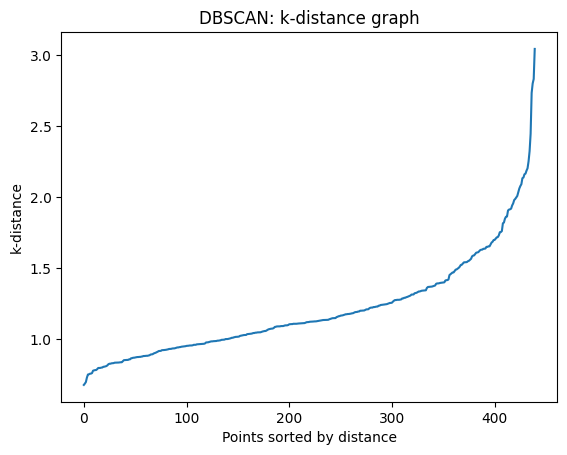

In [205]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=7)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,-1])
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Points sorted by distance")
plt.title("DBSCAN: k-distance graph")
plt.show()

In [206]:
eps_value = 1.00
min_samples_value = 7

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
db_labels = dbscan.fit_predict(X_scaled)

unique, counts = np.unique(db_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("DBSCAN cluster counts (including noise):", cluster_counts)

mask = db_labels != -1
num_clusters = len(set(db_labels[mask]))

if num_clusters >= 2:
    sil_db = silhouette_score(X_scaled[mask], db_labels[mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {sil_db:.2f}")
else:
    sil_db = None
    print("DBSCAN Silhouette Score cannot be computed: only 1 cluster after excluding noise")


DBSCAN cluster counts (including noise): {np.int64(-1): np.int64(174), np.int64(0): np.int64(96), np.int64(1): np.int64(150), np.int64(2): np.int64(7), np.int64(3): np.int64(7), np.int64(4): np.int64(6)}
DBSCAN Silhouette Score (excluding noise): 0.19
